In [1]:
import pandas as pd
import numpy as np

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
ml_trades = pd.read_csv(
    "data/ml_trades.csv",
    parse_dates=['date'],
    index_col='date'
)


In [3]:
ml_trades.head()


,open,high,low,close,volume,log_return,regime,signal,strategy_return,cum_market,...,ema_15,ema_signal,trade_signal,position,ml_position,future_return,trade_return,target,ml_confidence,ml_take_trade
date,,,,,,,,,,,,,,,,,,,,,
2024-07-30 13:00:00,24930.75,24933.55,24921.55,24927.75,0,-0.000008,-1.0,-1.0,0.000008,1.021001,...,24937.130659,-1,-1,-1,-1,-0.000251,0.000251,1,0.640107,True
2024-07-30 13:05:00,24928.45,24966.00,24926.05,24959.80,0,0.001285,-1.0,-1.0,0.000000,1.022314,...,24939.964326,1,0,0,1,-0.001935,-0.001935,0,0.232445,False
2024-07-30 13:15:00,24936.30,24944.55,24889.90,24898.25,0,-0.001553,-1.0,-1.0,0.001553,1.019793,...,24934.420344,-1,-1,-1,-1,0.001560,-0.001560,0,0.378508,False
2024-07-30 14:05:00,24922.35,24937.35,24921.40,24937.10,0,0.000582,-1.0,-1.0,0.000000,1.021384,...,24920.490115,1,0,0,1,-0.000938,-0.000938,0,0.321343,False
2024-07-30 14:55:00,24941.95,24947.15,24908.85,24913.70,0,-0.001105,-1.0,-1.0,0.001105,1.020426,...,24939.173023,-1,-1,-1,-1,-0.001052,0.001052,1,0.568131,True


In [4]:
ml_trades.columns



Index(['open', 'high', 'low', 'close', 'volume', 'log_return', 'regime',
       'signal', 'strategy_return', 'cum_market', 'cum_strategy', 'ema_5',
       'ema_15', 'ema_signal', 'trade_signal', 'position', 'ml_position',
       'future_return', 'trade_return', 'target', 'ml_confidence',
       'ml_take_trade'],
      dtype='object')

In [5]:
ml_trades.shape

(1293, 22)

In [6]:
profitable_trades = ml_trades[ml_trades['trade_return'] > 0].copy()


In [7]:
profitable_trades.shape


(600, 22)

In [8]:
from scipy.stats import zscore

profitable_trades['return_zscore'] = zscore(
    profitable_trades['trade_return']
)


In [9]:
profitable_trades['return_zscore'].describe()


count    6.000000e+02
mean     2.664535e-17
std      1.000834e+00
min     -8.019392e-01
25%     -6.265166e-01
50%     -3.230538e-01
75%      2.490564e-01
max      9.191411e+00
Name: return_zscore, dtype: float64

In [10]:
outlier_trades = profitable_trades[
    profitable_trades['return_zscore'] > 3
].copy()

normal_profitable_trades = profitable_trades[
    profitable_trades['return_zscore'] <= 3
].copy()


In [11]:
outlier_trades.shape



(11, 23)

In [12]:
normal_profitable_trades.shape

(589, 23)

In [13]:
outlier_trades['trade_return'].describe()

count    11.000000
mean      0.013269
std       0.005344
min       0.009440
25%       0.009752
50%       0.010833
75%       0.015203
max       0.024633
Name: trade_return, dtype: float64

In [14]:
spot = pd.read_csv(
    "data/spot_with_trades.csv",
    parse_dates=['date'],
    index_col='date'
)


In [15]:
spot.shape



(18676, 21)

In [16]:
spot.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_return', 'regime',
       'signal', 'strategy_return', 'cum_market', 'cum_strategy', 'ema_5',
       'ema_15', 'ema_signal', 'trade_signal', 'position', 'ml_position',
       'ml_strategy_return', 'ml_size', 'ml_sized_position',
       'ml_sized_return'],
      dtype='object')

In [17]:
spot.columns


Index(['open', 'high', 'low', 'close', 'volume', 'log_return', 'regime',
       'signal', 'strategy_return', 'cum_market', 'cum_strategy', 'ema_5',
       'ema_15', 'ema_signal', 'trade_signal', 'position', 'ml_position',
       'ml_strategy_return', 'ml_size', 'ml_sized_position',
       'ml_sized_return'],
      dtype='object')

In [18]:
spot = spot.copy()

spot['trade_id'] = np.nan
current_trade = -1

for i in range(1, len(spot)):
    prev_pos = spot['position'].iloc[i-1]
    curr_pos = spot['position'].iloc[i]

    # Trade entry
    if prev_pos == 0 and curr_pos != 0:
        current_trade += 1

    # Assign trade id if in trade
    if curr_pos != 0:
        spot.iloc[i, spot.columns.get_loc('trade_id')] = current_trade


In [19]:
spot['trade_id'].nunique()


647

In [20]:
trade_duration = (
    spot
    .dropna(subset=['trade_id'])
    .groupby('trade_id')
    .size()
    * 5
)

trade_duration.name = 'trade_duration_min'


In [21]:
trade_duration.describe()


count    647.000000
mean      72.132921
std       78.061425
min        5.000000
25%       20.000000
50%       45.000000
75%      100.000000
max      565.000000
Name: trade_duration_min, dtype: float64

In [23]:
spot = spot.copy()

spot['is_entry'] = (
    (spot['position'] != 0) &
    (spot['position'].shift(1) == 0)
)


In [24]:
spot['is_entry'].value_counts()


is_entry
False    18029
True       647
Name: count, dtype: int64

In [25]:
spot['trade_id'] = np.nan
current_trade = -1

for i in range(len(spot)):
    if spot['is_entry'].iloc[i]:
        current_trade += 1
    if spot['position'].iloc[i] != 0:
        spot.iloc[i, spot.columns.get_loc('trade_id')] = current_trade


In [26]:
spot['trade_id'].nunique()


647

In [27]:
trade_duration = (
    spot
    .dropna(subset=['trade_id'])
    .groupby('trade_id')
    .size()
    * 5
)

trade_duration.name = 'trade_duration_min'


In [33]:
ml_trades = ml_trades.copy()

ml_trades['trade_id'] = np.arange(len(ml_trades))


In [34]:
ml_trades['trade_id'].head()


date
2024-07-30 13:00:00    0
2024-07-30 13:05:00    1
2024-07-30 13:15:00    2
2024-07-30 14:05:00    3
2024-07-30 14:55:00    4
Name: trade_id, dtype: int64

In [36]:
ml_trades = ml_trades.merge(
    trade_duration,
    on='trade_id',
    how='left'
)


In [37]:
ml_trades['trade_duration_min'].describe()



count    647.000000
mean      72.132921
std       78.061425
min        5.000000
25%       20.000000
50%       45.000000
75%      100.000000
max      565.000000
Name: trade_duration_min, dtype: float64

In [38]:
ml_trades['trade_duration_min'].isna().sum()

np.int64(646)

In [39]:
ml_trades['trade_duration_min'].describe()


count    647.000000
mean      72.132921
std       78.061425
min        5.000000
25%       20.000000
50%       45.000000
75%      100.000000
max      565.000000
Name: trade_duration_min, dtype: float64

In [41]:
ml_trades[['trade_return']].describe()


,trade_return
count,1293.000000
mean,-0.000072
std,0.003087
min,-0.038772
25%,-0.001221
50%,-0.000134
75%,0.001025
max,0.024633


In [42]:
from scipy.stats import zscore

ml_trades = ml_trades.copy()

ml_trades['return_zscore'] = zscore(ml_trades['trade_return'])


In [43]:
ml_trades['return_zscore'].describe()


count    1.293000e+03
mean    -1.648591e-17
std      1.000387e+00
min     -1.254295e+01
25%     -3.725148e-01
50%     -2.007957e-02
75%      3.555514e-01
max      8.007289e+00
Name: return_zscore, dtype: float64

In [44]:
outlier_trades = ml_trades[ml_trades['return_zscore'] > 3]
normal_profitable_trades = ml_trades[
    (ml_trades['trade_return'] > 0) &
    (ml_trades['return_zscore'] <= 3)
]



In [48]:
outlier_trades.shape


(11, 27)

In [47]:
normal_profitable_trades.shape


(589, 27)

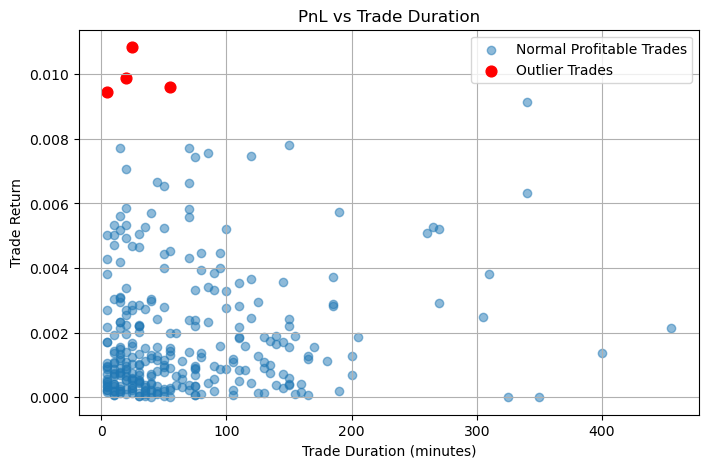

In [46]:
plt.figure(figsize=(8, 5))

plt.scatter(
    normal_profitable_trades['trade_duration_min'],
    normal_profitable_trades['trade_return'],
    alpha=0.5,
    label='Normal Profitable Trades'
)

plt.scatter(
    outlier_trades['trade_duration_min'],
    outlier_trades['trade_return'],
    color='red',
    s=60,
    label='Outlier Trades'
)

plt.xlabel("Trade Duration (minutes)")
plt.ylabel("Trade Return")
plt.title("PnL vs Trade Duration")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
features_to_compare = [
    'trade_duration_min',
    'recent_volatility',
    'ema_distance',
    'regime'
]



In [51]:
outlier_trades['trade_duration_min'].describe()


count     4.000000
mean     26.250000
std      20.966243
min       5.000000
25%      16.250000
50%      22.500000
75%      32.500000
max      55.000000
Name: trade_duration_min, dtype: float64

In [52]:
boxplot_df = pd.concat([
    normal_profitable_trades[['trade_duration_min']].assign(type='Normal'),
    outlier_trades[['trade_duration_min']].assign(type='Outlier')
])


In [53]:
boxplot_df['type'].value_counts()


type
Normal     589
Outlier     11
Name: count, dtype: int64

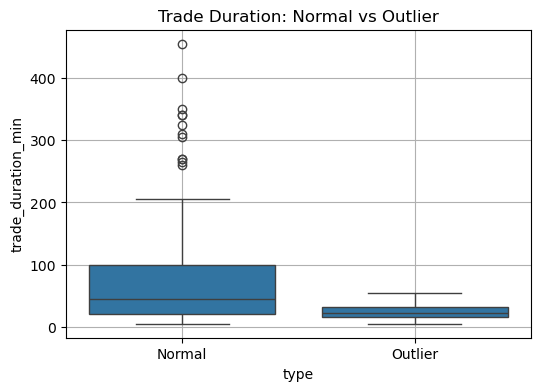

In [54]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=boxplot_df,
    x='type',
    y='trade_duration_min'
)
plt.title('Trade Duration: Normal vs Outlier')
plt.grid(True)
plt.show()


In [55]:
outlier_trades['trade_duration_min'].describe()


count     4.000000
mean     26.250000
std      20.966243
min       5.000000
25%      16.250000
50%      22.500000
75%      32.500000
max      55.000000
Name: trade_duration_min, dtype: float64